In [1]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, writefile, time_func, utils as ut, utils0 as ut0
from scipy import signal
from scipy.interpolate import Rbf
from urllib.request import urlretrieve

from matplotlib.backends.backend_pdf import PdfPages

In [59]:
InSAR_ifgstack_filename =  r'C:\Users\bvarugu\Documents\Concord\inputs\ifgramStack.h5';
stack_obj = ifgramStack(InSAR_ifgstack_filename);
date12List = stack_obj.get_date12_list(dropIfgram=False);
date_list =stack_obj.get_date_list();
insar_metadata = stack_obj.get_metadata();
unwPhase = stack_obj.read(datasetName='unwrapPhase')
# get analysis metadata from InSAR velocity file
lat_step = float(insar_metadata['Y_STEP'])
lon_step = float(insar_metadata['X_STEP'])
(S,N,W,E) = ut.four_corners(insar_metadata)
start_date = insar_metadata.get('START_DATE', None)
end_date = insar_metadata.get('END_DATE', None)
start_date_gnss = dt.datetime.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.datetime.strptime(end_date, "%Y%m%d")
print(len(date12List))

reading unwrapPhase data from file: C:\Users\bvarugu\Documents\Concord\inputs\ifgramStack.h5 ...
322


In [61]:
len(date12List)

322

In [65]:
gnss_source = 'ESESES';
site_names, site_lats, site_lons = gnss.search_gnss(SNWE=(S,N,W,E), source=gnss_source,start_date=start_date, end_date=end_date);
site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

azimuthAngle = readfile.read(r'C:\Users\bvarugu\Documents\Concord\geometryGeo.h5',datasetName='azimuthAngle')[0];
incidenceAngle = readfile.read(r'C:\Users\bvarugu\Documents\Concord\geometryGeo.h5',datasetName='incidenceAngle')[0];
site_Y,site_X = ut.coordinate(insar_metadata).geo2radar(site_lats, site_lons)[0:2];
site_azimuthAngles = [azimuthAngle[row,col] for row, col in zip(site_Y,site_X)];
site_incidenceAngles = [incidenceAngle[row,col] for row, col in zip(site_Y,site_X)];

load 3655 GNSS sites with fields: site lon lat
keep sites within SNWE of (35.580819101, 37.403318372, -121.670784665, -118.501619266): [134]
['ALTH' 'CAND' 'CARH' 'CARR' 'CHOW' 'CRBT' 'CRCN' 'DLNO' 'DOND' 'DONO'
 'DREW' 'GR8R' 'GRN5' 'HELB' 'HELP' 'HOGS' 'HUNT' 'JLN5' 'KDCB' 'KDL1'
 'LAND' 'LEMA' 'LNCO' 'LOWS' 'MASW' 'MEE1' 'MEE2' 'MHCB' 'MIDA' 'MNMC'
 'MRCD' 'MULN' 'MUSB' 'P056' 'P173' 'P174' 'P175' 'P180' 'P217' 'P232'
 'P233' 'P234' 'P235' 'P236' 'P237' 'P238' 'P239' 'P240' 'P241' 'P242'
 'P243' 'P244' 'P247' 'P249' 'P250' 'P251' 'P252' 'P258' 'P278' 'P279'
 'P281' 'P282' 'P283' 'P284' 'P285' 'P286' 'P287' 'P288' 'P289' 'P290'
 'P291' 'P292' 'P293' 'P294' 'P295' 'P296' 'P297' 'P298' 'P299' 'P300'
 'P301' 'P302' 'P303' 'P304' 'P305' 'P307' 'P311' 'P526' 'P527' 'P530'
 'P531' 'P532' 'P533' 'P539' 'P540' 'P541' 'P542' 'P544' 'P546' 'P547'
 'P552' 'P564' 'P565' 'P566' 'P571' 'P572' 'P576' 'P578' 'P602' 'P629'
 'P723' 'P725' 'P782' 'P787' 'P788' 'P789' 'P790' 'P809' 'P810' 'PBHR'
 'PEA1'

In [67]:
def standardize_longitude(lon, limit='-180to180'):
    """Normalize the longitude value range into (-180, 180] or [0, 360).

    Parameters: lon   - float / np.ndarray, longitude in degree
                limit - str, -180to180 or 0to360
    Returns:    lon   - float / np.ndarray, longitude in degree
    """
    lon = np.asarray(lon)

    # ensure data within (-180, 360)
    lon = np.where(lon >= 360, lon - 360, lon)
    lon = np.where(lon <= -180, lon + 360, lon)

    # range option 1: ensure data within (-180, 180]
    if limit == '-180to180':
        lon = np.where(lon > 180, lon - 360, lon)

    # range option 2: ensure data within [0, 360)
    elif limit == '0to360' and np.nanmin(lon) < 0:
        lon = np.where(lon < 0, lon + 360, lon)

    return float(lon) if np.isscalar(lon) else lon
    
class GNSS_ESESES:
    """GNSS child class for daily solutions processed for the Enhanced Solid
    Earth Science ESDR System (ESESES) project by JPL and SOPAC.

    Website: https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/ESESES_products.html
             http://garner.ucsd.edu/pub/measuresESESES_products/
    """
    def __init__(self, site: str, data_dir=None, version='IGS14', url_prefix=None):
        self.site = site
        self.data_dir = data_dir or os.getcwd()  # Default to current working directory
        self.version = version
        self.source = 'ESESES'
        self.url_prefix = url_prefix
        

        # get file
        self.file = os.path.join(self.data_dir, f'{self.site.lower():s}CleanTrend.neu.Z')

        # get url
        # moved to GNSS_ESESES.dload_site() to avoid searching url_prefix
        # when downloading is not needed.


    def dload_site(self, overwrite=True, total_tries=5, print_msg=True):
        """Download GNSS data file.
        """
        from zipfile import ZipFile

        # get url
        if not self.url_prefix:
            self.url_prefix = gnss.get_ESESES_url_prefix()
        self.url = os.path.join(self.url_prefix, os.path.basename(self.file)).replace("\\", "/");#print('URL is',self.url);
        if self.url and overwrite or not os.path.isfile(self.file):
            print(f"downloading site {self.site:s} from {self.source} to {self.file:s}")
            # retry on download fail
            # https://stackoverflow.com/questions/31529151
            remain_tries = total_tries
            while remain_tries > 0 :
                try:
                    urlretrieve(self.url, self.file)
                    print(f'successfully downloaded: {self.url}')
                except:
                    print(f'error downloading {self.url} on trial no. {total_tries-remain_tries}')
                    remain_tries -= 1
                    continue
                else:
                    break

        # call parent class to download
        #super().dload_site(overwrite=overwrite, print_msg=print_msg)

        # uncompress the downloaded *.z file [for ESESES only]
        with ZipFile(self.file, 'r') as fz:
            fz.extractall(self.data_dir)
        self.file = self.file.strip('.Z')    # update file name
        if print_msg:
            print(f'... extracted to {self.file:s}')

        return self.file


    def get_site_lat_lon(self, print_msg=False) -> (float, float):
        """Get station lat/lon based on processing source.
        Retrieve data from the displacement file.

        Modifies:   self.lat/lon - float
        Returns:    self.lat/lon - float
        """
        # download file if it does not exist
        if not os.path.isfile(self.file):
            self.dload_site(print_msg=print_msg)

        # use the uncompressed data file
        if self.file.endswith('.Z'):
            self.file = self.file[:-2]

        with open(self.file) as f:
            lines = f.readlines()

            # latitude
            lat_line = [x for x in lines if x.startswith('# Latitude')][0].strip('\n')
            self.site_lat = float(lat_line.split()[-1])

            # longitude
            lon_line = [x for x in lines if x.startswith('# East Longitude')][0].strip('\n')
            self.site_lon = float(lon_line.split()[-1])

        # ensure longitude in the range of (-180, 180]
        self.site_lon = standardize_longitude(self.site_lon, limit='-180to180')

        return self.site_lat, self.site_lon
    def _crop_to_date_range(self, start_date: str, end_date: str):
        """Crop the time-series given the start/end_date in format YYYYMMDD,
        and create date_list from dates.
        """
        flag = np.ones(len(self.dates), dtype=bool)
        if start_date:
            t0 = ptime.date_list2vector([start_date])[0][0]
            flag[self.dates < t0] = 0
        if end_date:
            t1 = ptime.date_list2vector([end_date])[0][0]
            flag[self.dates > t1] = 0

        self.dates = self.dates[flag]
        self.dis_e = self.dis_e[flag]
        self.dis_n = self.dis_n[flag]
        self.dis_u = self.dis_u[flag]
        self.std_e = self.std_e[flag]
        self.std_n = self.std_n[flag]
        self.std_u = self.std_u[flag]

        # create member var: date_list
        self.date_list = [x.strftime('%Y%m%d') for x in self.dates]


    def read_displacement(self, start_date=None, end_date=None, print_msg=True, display=False):
        """Read GNSS displacement time-series (defined by start/end_date).

        Parameters: start/end_date - str, date in YYYYMMDD format
        Returns:    dates          - 1D np.ndarray of datetime.datetime object
                    dis_e/n/u      - 1D np.ndarray of displacement in meters in float32
                    std_e/n/u      - 1D np.ndarray of displacement STD in meters in float32
        """
        vprint = print if print_msg else lambda *args, **kwargs: None

        # download file if it does not exist
        if not os.path.isfile(self.file):
            self.dload_site(print_msg=print_msg)

        # use the uncompressed data file
        if self.file.endswith('.Z'):
            self.file = self.file[:-2]

        # read data file
        # use the first 9 cols only, as some epoches miss 10-13 cols: CorrNE/NU/EU, Chi-Squared
        #print('reading time and displacement in east/north/vertical direction')
        fc = np.loadtxt(self.file, usecols=tuple(range(0,9)))
        num_solution = fc.shape[0]

        # parse dates
        dates = [dt.datetime(int(fc[i, 1]), 1, 1) + dt.timedelta(days=int(fc[i, 2]))
                 for i in range(num_solution)]
        self.dates = np.array(dates)

        # parse displacement data
        (self.dis_n,
         self.dis_e,
         self.dis_u,
         self.std_n,
         self.std_e,
         self.std_u) = fc[:, 3:9].astype(np.float32).T / 1000

        # cut out the specified time range
        self._crop_to_date_range(start_date, end_date)

        # display if requested
        if display:
            self.plot()

        return (self.dates,
                self.dis_e, self.dis_n, self.dis_u,
                self.std_e, self.std_n, self.std_u)


gps_dir = r'C:\Users\bvarugu\Documents\Concord\GNSS_ESESES'; #os.path.join(os.path.dirname(InSAR_ts_filename),'GNSS_ESESES');
gps_plot_dir = os.path.join(gps_dir,'GNSS_plot');
os.makedirs(gps_plot_dir,exist_ok=True)

In [9]:
len(unwPhase)

322

In [35]:
ptime.date_list2vector(date12List[0].split('_'))[0]

[datetime.datetime(2022, 3, 19, 0, 0), datetime.datetime(2022, 3, 31, 0, 0)]

In [69]:
sar_wavelength = float(insar_metadata['WAVELENGTH']);

In [71]:
wind=2;
num_date = len(date12List)

site_displacements = np.zeros([len(site_names),num_date]);
site_insar_displacements = np.zeros([len(site_names),num_date]);
for i, site_name in enumerate(site_names):
    gnss_obj = GNSS_ESESES(site =site_name,data_dir=gps_dir);gnss_obj.read_displacement();
    #gnss_obj._crop_to_date_range(start_date= date0, end_date= date1);
    gnss_obj_dis_los = ut.enu2los(gnss_obj.dis_e,gnss_obj.dis_n, gnss_obj.dis_u, site_incidenceAngles[i], site_azimuthAngles[i]);
    y, x = int(site_Y[i]),int(site_X[i]);
    for j in range(num_date):
        unw_phase = unwPhase[j];
        [date1,date2] = ptime.date_list2vector(date12List[j].split('_'))[0]
        date1_index = np.where(gnss_obj.dates == date1)[0];date2_index = np.where(gnss_obj.dates == date2)[0];
        
        try:
            site_displacements[i,j]= (gnss_obj_dis_los[date2_index][0]-gnss_obj_dis_los[date1_index][0])*(-4*np.pi/sar_wavelength);
        except:
            site_displacements[i,j]= np.nan;
        site_insar_displacements[i,j] = np.nanmean(unw_phase[y-wind:y+wind, x-wind:x+wind],axis=(0,1));


C:\Users\bvarugu\AppData\Local\Temp\ipykernel_22536\1156922411.py:20: RuntimeWarning: Mean of empty slice
  site_insar_displacements[i,j] = np.nanmean(unw_phase[y-wind:y+wind, x-wind:x+wind],axis=(0,1));


In [73]:
len(date12List)

322

In [75]:
def get_surface(station_names,station_Y,station_X,station_velocities,station_insar_velocites,insar_velocity):
    station_names = np.array(station_names);
    station_Y = np.array(station_Y);
    station_X = np.array(station_X);
    median_velocity = np.nanmedian(station_velocities)
    print('Remove NaN Values and velcoties grater than median velocity:{}'.format(median_velocity))
    valid_points = (~np.isnan(station_velocities)) & (~np.isnan(station_insar_velocites))
    station_X_valid = station_X[valid_points]
    station_Y_valid = station_Y[valid_points]
    station_velocities_valid = station_velocities[valid_points];
    station_insar_velocities_valid = station_insar_velocites[valid_points];
    station_names_valid = station_names[valid_points];
    
    print('Remove Duplicates')
    # Combine station_X_valid and station_Y_valid into a single array of coordinates
    coords = np.array(list(zip(station_X_valid, station_Y_valid)))
    
    # Find unique coordinates and their indices
    _, unique_indices = np.unique(coords, axis=0, return_index=True)
    
    # Use these indices to filter station_X_valid, station_Y_valid, station_velocities_valid, and station_names_valid
    station_X_unique = station_X_valid[unique_indices]
    station_Y_unique = station_Y_valid[unique_indices]
    station_velocities_unique = station_velocities_valid[unique_indices]
    station_insar_velocities_unique = station_insar_velocities_valid[unique_indices]
    station_names_unique = station_names_valid[unique_indices]
    station_residual_velocities_unique = station_velocities_unique-station_insar_velocities_unique
    rbf_interpolator = Rbf(station_X_unique, station_Y_unique, station_residual_velocities_unique, function='linear')
    rbf_interpolator2 = Rbf(station_X_unique, station_Y_unique, station_velocities_unique, function='linear')
    # Define grid for interpolation (extend beyond the data range)
    length, width = np.shape(insar_velocity)
    grid_Y, grid_X = np.arange(0, length), np.arange(0,width)
    grid_X, grid_Y = np.meshgrid(grid_X, grid_Y)
    
    # Interpolate on the extended grid
    z_grid_extended = rbf_interpolator(grid_X, grid_Y)
    gnss_vel_grid = rbf_interpolator2(grid_X, grid_Y)
    return z_grid_extended,gnss_vel_grid

gnss_stack = np.zeros(np.shape(unwPhase), dtype=np.float32)
residual_stack = np.zeros(np.shape(unwPhase), dtype=np.float32)
for k,date in enumerate(date12List):
    residual_stack[k,:,:],gnss_stack[k,:,:]  = get_surface(site_names,site_Y,site_X,site_displacements[:,k],site_insar_displacements[:,k],
                                                        unwPhase[0]);

Remove NaN Values and velcoties grater than median velocity:0.8346983637251382
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:-0.1385083938553311
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:-0.983581688991497
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:0.15521040871746894
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:1.09298182754999
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:0.5127655291485638
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:-0.5766309651792141
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:0.003505152747610209
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:0.4727006119973341
Remove Duplicates
Remove NaN Values and velcoties grater than median velocity:2.1852977351582843
Remove Duplicates
Remove NaN Values and velco

In [76]:
corrected_stack = unwPhase + residual_stack;


In [77]:
import h5py
import time
output_dataset = 'unwrapPhaseGnss' # output dataset
#stack_obj.open(print_msg=False)

ifgram_file = r'C:\Users\bvarugu\Documents\Concord\inputs\ifgramStack_gnss.h5';
dsNameOut = output_dataset
num_ifgrams = len(date12List)
shape_out = np.shape(unwPhase);
# prepare output data writing
print('open {} with r+ mode'.format(ifgram_file))
f = h5py.File(ifgram_file, 'r+')

print('output dataset:', dsNameOut)
if dsNameOut in f.keys():
    ds = f[dsNameOut]
    print('access /{d} of np.float32 in size of {s}'.format(d=dsNameOut, s=shape_out))
else:
    ds = f.create_dataset(dsNameOut,
                          shape_out,
                          maxshape=(None, None, None),
                          chunks=True,
                          compression=None)
    print('create /{d} of np.float32 in size of {s}'.format(d=dsNameOut, s=shape_out))
# write to hdf5 file
for j in range(len(date12List)):
    ds[j,:,:] = corrected_stack[j,:,:];
# ds[ifg_location, :, :] = igram_unw  # original
ds.attrs['MODIFICATION_TIME'] = str(time.time())
f.close()
print('close {} file.'.format(ifgram_file))

open C:\Users\bvarugu\Documents\Concord\inputs\ifgramStack_gnss.h5 with r+ mode
output dataset: unwrapPhaseGnss
access /unwrapPhaseGnss of np.float32 in size of (322, 2187, 3803)
close C:\Users\bvarugu\Documents\Concord\inputs\ifgramStack_gnss.h5 file.


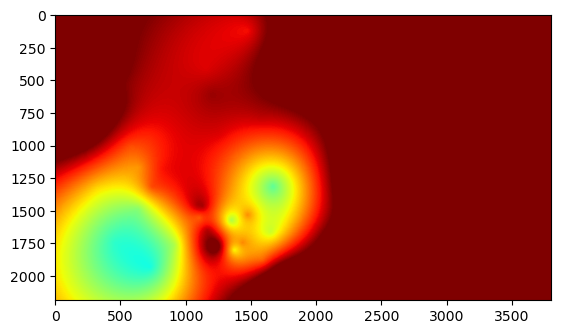

In [37]:
plt.imshow(residual_stack[130],cmap='jet',vmin=-6.28,vmax=6.28)

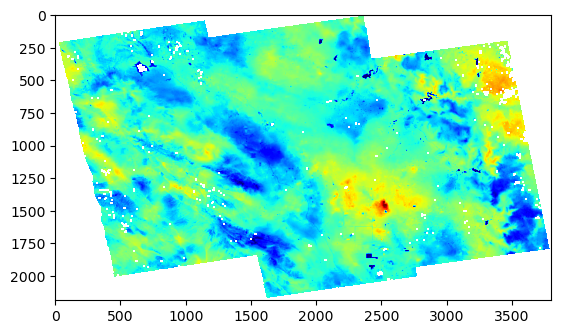

In [23]:
plt.imshow(corrected_stack[1],cmap='jet',vmin=-6.28,vmax=6.28)